# JS-BSON and BSON-EXT Performance comparison

## Aim

The bson-ext library has been untouched for the better part of a year, but still has Over 10,000 weekly downloads. Its purpose was to provide a higher-performance bson serializer than the main bson serialization library in the Node ecosystem, js-bson, which is the library that we use internally in the Node driver. Due to a number of inconsistencies and the overhead of maintaning this additional library, the Node team intends to sunset this library. To get an understanding of where if anywhere js-bson needs to be improved to provide performance on-par with or better than bson-ext, we have undertaken the task of benchmarking both libraries.

## Methodology


## Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import re
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [9,6]

In [2]:
import os
csvs = list(filter(lambda f: f.endswith('.csv'), os.listdir('../results')))
pprint(csvs)

['regexResults.csv',
 'nullResults.csv',
 'dateResults.csv',
 'decimal128Results.csv',
 'int32Results.csv',
 'booleanResults.csv',
 'longResults.csv',
 'minkeyResults.csv',
 'mixedDocumentsResults.csv',
 'objectidResults.csv',
 'maxkeyResults.csv',
 'codeResults.csv',
 'stringResults.csv',
 'binaryResults.csv',
 'doubleResults.csv']


In [3]:
documents = {}
# add stderr column
for csv in csvs:
    documents[csv] = pd.read_csv('../results/' + csv)
    documents[csv]['stderr'] = documents[csv]['stddev']/np.sqrt(documents[csv]['iterations'])

In [4]:
# Need to see bar charts for each test scenario grouped by bson version and relevant options
documents

{'regexResults.csv':                                  test_name         library         max  \
 0   regex_singleFieldDocument._deserialize      bson@6.2.0   13.377877   
 1   regex_singleFieldDocument._deserialize      bson@6.2.0   13.050566   
 2     regex_singleFieldDocument._serialize      bson@6.2.0   15.748056   
 3    regex_singleElementArray._deserialize      bson@6.2.0   11.709232   
 4    regex_singleElementArray._deserialize      bson@6.2.0   16.348853   
 5      regex_singleElementArray._serialize      bson@6.2.0   13.894255   
 6             regex_array_100._deserialize      bson@6.2.0   36.371900   
 7             regex_array_100._deserialize      bson@6.2.0   32.208047   
 8               regex_array_100._serialize      bson@6.2.0   71.431980   
 9              regex_array_10._deserialize      bson@6.2.0   33.690928   
 10             regex_array_10._deserialize      bson@6.2.0   29.881046   
 11               regex_array_10._serialize      bson@6.2.0   58.317186   
 12  

In [5]:
# UTILITIES
BAR_LABEL_CONFIG = {
    'rotation': 'vertical',
    'label_type': 'center',
    'padding': 3
    
}

def filterFor(df, testSpec,
              promoteValues='-',
              promoteLongs='-',
              promoteBuffers='-',
              useBigInt64='-',
              checkKeys='-',
              ignoreUndefined='-',
              bsonRegExp='-',
              utf8Validation='-'):
    if promoteValues != '-':
        df = df[df['promoteValues'] == promoteValues]
    if promoteLongs != '-':
        df = df[df['promoteLongs'] == promoteLongs]
    if promoteBuffers != '-':
        df = df[df['promoteBuffers'] == promoteBuffers]
    if useBigInt64 != '-':
        df = df[df['useBigInt64'] == useBigInt64]
    if checkKeys != '-':
        df = df[df['checkKeys'] == checkKeys]
    if ignoreUndefined != '-':
        df = df[df['ignoreUndefined'] == ignoreUndefined]
    if bsonRegExp != '-':
        df = df[df['bsonRegExp'] == bsonRegExp]
    if utf8Validation != '-':
        df = df[df['utf8Validation'] == utf8Validation]
        
    return df[df['test_name'].str.contains(testSpec)]


def createSimpleGraph(df, testSpec, title,
                      promoteValues='-',
                      promoteLongs='-',
                      promoteBuffers='-',
                      useBigInt64='-',
                      checkKeys='-',
                      ignoreUndefined='-',
                      bsonRegExp='-',
                      utf8Validation='-'):
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    
    results = filterFor(df, testSpec, **kwargs)
    width = 0.25
    versions = results['library'].values
    fix, ax = plt.subplots()

    x = np.arange(len(versions))
    rects = ax.bar(x, results['mean'])

    ax.set_ylabel('Throughput (MB/s)')
    ax.set_title(title)
    ax.set_xticks(x, versions)
    plt.grid(True)

    plt.show()
    
def createSimpleGraphPct(df, testSpec, title,
                         promoteValues='-',
                         promoteLongs='-',
                         promoteBuffers='-',
                         useBigInt64='-',
                         checkKeys='-',
                         ignoreUndefined='-',
                         bsonRegExp='-',
                         utf8Validation='-'):
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    results = addPercentImprovementOverBSONEXT(filterFor(df, testSpec,**kwargs))
    width = 0.25
    versions = results['library'].values
    fix, ax = plt.subplots()

    x = np.arange(len(versions))
    rects = ax.bar(x, results['pctImprovementOverBsonExt']* 100)

    ax.set_ylabel('% speedup over bson-ext')
    ax.set_title(title)
    ax.set_xticks(x, versions)
    plt.grid(True)

    plt.show()

def addPercentImprovementOverBSONEXT(df):
    relevantRow = df[df['library'].str.contains('bson-ext')]
    if len(relevantRow) > 1:
        raise ValueError('dataframe not constrained enough')
    if len(relevantRow) == 0:
        raise ValueError('dataframe overconstrained')
    mean = relevantRow['mean'].values[0]
    col = df.apply(lambda r: (r['mean'] - mean)/mean, axis=1)
    return df.assign(pctImprovementOverBsonExt=col.values)
    

def createArrayGraph(df, operation, title,
                     promoteValues='-',
                     promoteLongs='-',
                     promoteBuffers='-',
                     useBigInt64='-',
                     checkKeys='-',
                     ignoreUndefined='-',
                     bsonRegExp='-',
                     utf8Validation='-',
                     ylim=100):
    
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    if operation != 'serialize' and operation != 'deserialize':
        raise ValueError('Invalid operation')
    
    array10Results = filterFor(df, 'array_10._'+operation, **kwargs)
    array100Results = filterFor(df, 'array_100._'+operation, **kwargs)
    array1000Results = filterFor(df, 'array_1000._'+operation,**kwargs)
    versions = array10Results['library'].values

    measurements = {
        10: array10Results,
        100: array100Results,
        1000: array1000Results
    }

    #print(array10Results)
    x = np.arange(len(versions))
    # map version to n=10,n=100, n=1000 results
    results = {}
    for __n in [10, 100, 1000]:
        results[__n] = []

    for version in array10Results['library']:
        for n, res in measurements.items():
            results[n].append(res.loc[res['library'] == version, 'mean'].values[0])


    width = 0.25
    mult = 0
    fig, ax1 = plt.subplots()
    for _n, measurement in results.items():
        offset = width * mult
        rects = ax1.bar(x+offset, measurement, width, label=f"n={_n}")
        ax1.bar_label(rects, **BAR_LABEL_CONFIG)
        mult += 1

    ax1.set_ylabel('Throughput (MB/s)')
    ax1.set_title(title)
    ax1.set_xticks(x+width, versions)
    ax1.legend(loc='upper left', ncols=len(versions))
    ax1.set_ylim(0, ylim)

    plt.xticks(rotation=45)
    plt.show()
    
    
def createArrayGraphPct(df, operation, title,
                     promoteValues='-',
                     promoteLongs='-',
                     promoteBuffers='-',
                     useBigInt64='-',
                     checkKeys='-',
                     ignoreUndefined='-',
                     bsonRegExp='-',
                     utf8Validation='-',
                     ylim0=-45,
                     ylim1=100):
    if operation != 'serialize' and operation != 'deserialize':
        raise ValueError('Invalid operation')
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    array10Results = addPercentImprovementOverBSONEXT(filterFor(df, 'array_10._'+operation, **kwargs))
    array100Results = addPercentImprovementOverBSONEXT(filterFor(df, 'array_100._'+operation, **kwargs))
    array1000Results = addPercentImprovementOverBSONEXT(filterFor(df, 'array_1000._'+operation, **kwargs))

    versions = array10Results['library'].values

    measurements = {
        10: array10Results,
        100: array100Results,
        1000: array1000Results
    }

    #print(array10Results)
    x = np.arange(len(versions))
    # map version to n=10,n=100, n=1000 results
    results = {}
    for __n in [10, 100, 1000]:
        results[__n] = []

    for version in array10Results['library']:
        for n, res in measurements.items():
            results[n].append(res.loc[res['library'] == version, 'pctImprovementOverBsonExt'].values[0]*100)


    width = 0.25
    mult = 0
    fig, ax1 = plt.subplots()
    for _n, measurement in results.items():
        offset = width * mult
        rects = ax1.bar(x+offset, measurement, width, label=f"n={_n}")
        ax1.bar_label(rects, fmt='%.3f', **BAR_LABEL_CONFIG)
        mult += 1

    ax1.set_ylabel('% speedup over bson-ext')
    ax1.set_title(title)
    ax1.set_xticks(x+width, versions)
    ax1.legend(loc='upper left', ncols=len(versions))
    ax1.set_ylim(ylim0, ylim1)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    
def createMixedGraphs(df, operation, title, ylim0=0, ylim1=100):
    if operation != 'serialize' and operation != 'deserialize':
        raise ValueError('Invalid operation')
    
    smallResults = filterFor(df, 'small._'+operation)
    mediumResults = filterFor(df, 'medium._'+operation)    
    largeResults = filterFor(df, 'large._'+operation)
    tweetResults = filterFor(df, 'tweet._'+operation)
    bestbuyResults = filterFor(df, 'bestbuy_medium._'+operation)
    
    versions = smallResults['library'].values
    
    measurements = {
        'small': smallResults,
        'medium': mediumResults,
        'large': largeResults,
        'tweet': tweetResults,
        'bestbuy_medium': bestbuyResults
    }
    
    x = np.arange(len(versions))
    results = {}
    for __n in measurements.keys():
        results[__n] = []

    for version in smallResults['library']:
        for n, res in measurements.items():
            value = res.loc[res['library'] == version, 'mean'].values[0]
            print(value)
            results[n].append(value)


    width = 0.15
    mult = 0
    fig, ax1 = plt.subplots()
    for size, measurement in results.items():
        offset = width * mult
        rects = ax1.bar(x+offset, measurement, width, label=size)
        ax1.bar_label(rects, fmt='%.3f', **BAR_LABEL_CONFIG)
        mult += 1

    ax1.set_ylabel('Throughput (MB/s)')
    ax1.set_title(title)
    ax1.set_xticks(x+width, versions)
    ax1.legend(loc='upper left', ncols=len(versions))
    ax1.set_ylim(ylim0, ylim1)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Long Results

## Deserialize

### Array

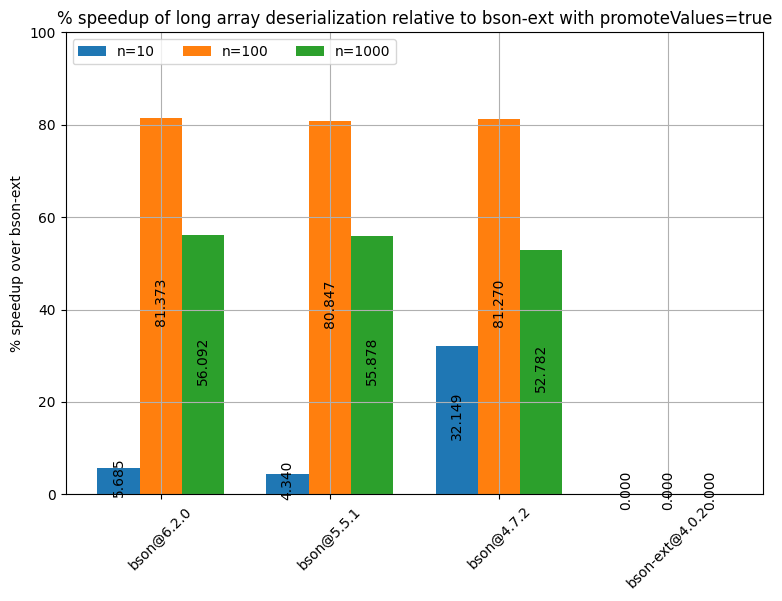

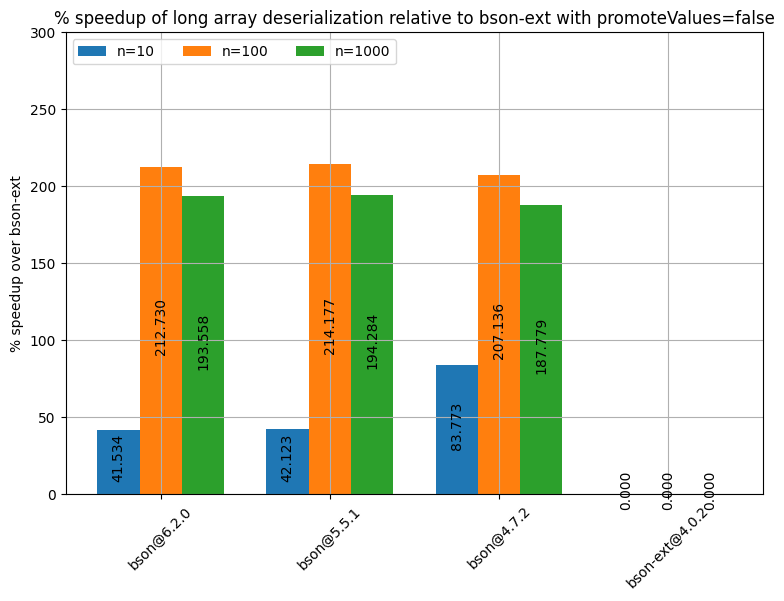

In [6]:
createArrayGraphPct(documents['longResults.csv'], 'deserialize', '% speedup of long array deserialization relative to bson-ext with promoteValues=true', promoteValues='1', ylim0=0 )
createArrayGraphPct(documents['longResults.csv'], 'deserialize', '% speedup of long array deserialization relative to bson-ext with promoteValues=false', promoteValues='0', ylim0=0, ylim1=300 )

### Single element Array and Single Field document

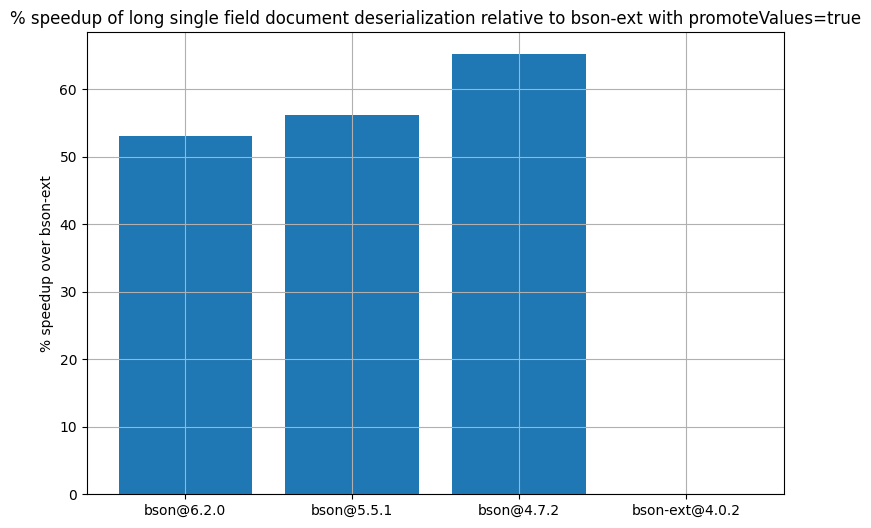

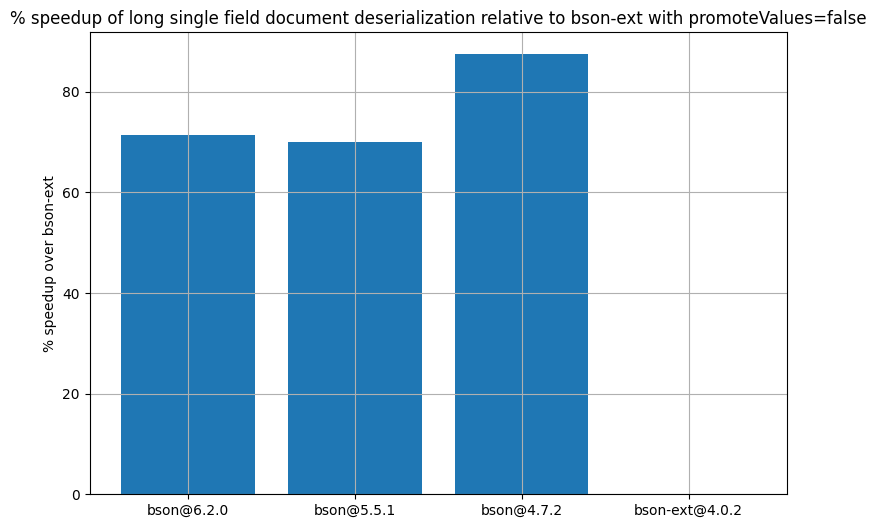

In [7]:
longResults = documents['longResults.csv']

createSimpleGraphPct(longResults, '_singleFieldDocument._deserialize', '% speedup of long single field document deserialization relative to bson-ext with promoteValues=true', promoteValues='1')
createSimpleGraphPct(longResults, '_singleFieldDocument._deserialize', '% speedup of long single field document deserialization relative to bson-ext with promoteValues=false', promoteValues='0')

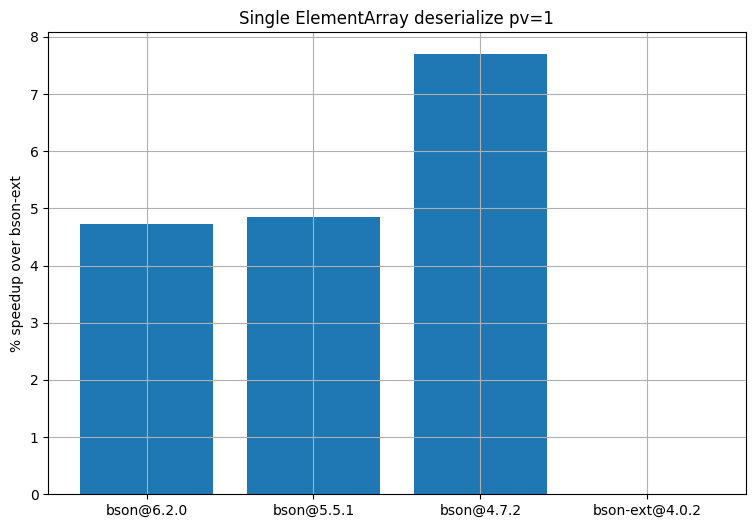

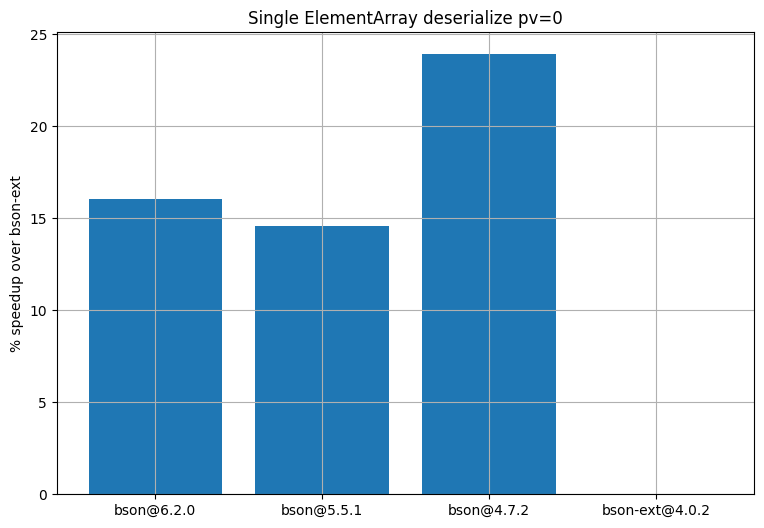

In [8]:
longResults = documents['longResults.csv']
createSimpleGraphPct(longResults, '_singleElementArray._deserialize', 'Single ElementArray deserialize pv=1', promoteValues='1')
createSimpleGraphPct(longResults, '_singleElementArray._deserialize', 'Single ElementArray deserialize pv=0', promoteValues='0')

## Serialize

### Array

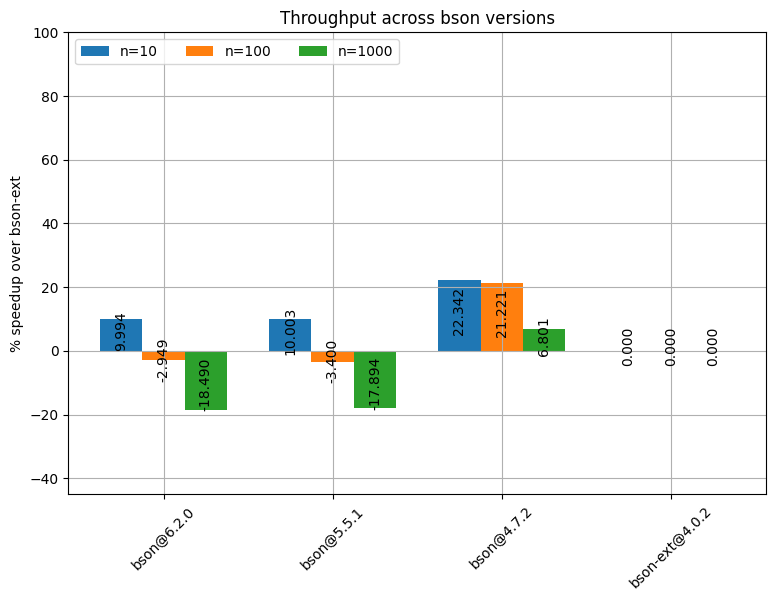

In [9]:
createArrayGraphPct(documents['longResults.csv'], 'serialize', 'Throughput across bson versions')

### Single element and single field

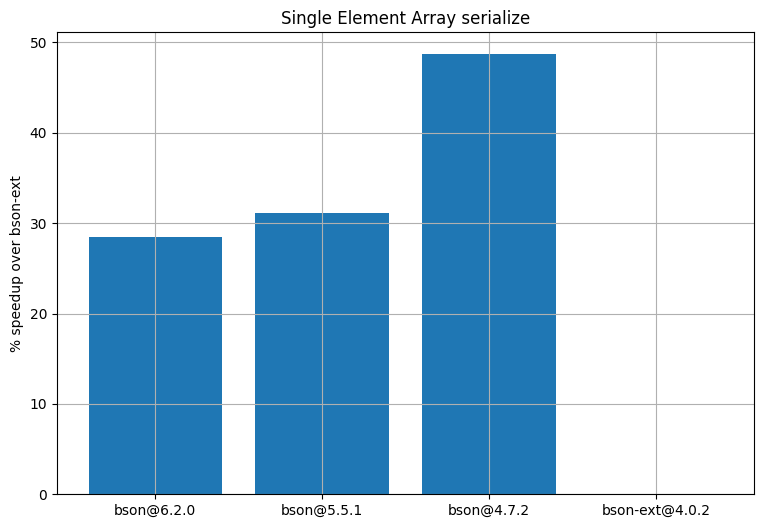

In [10]:
longResults = documents['longResults.csv']

createSimpleGraphPct(longResults, '_singleElementArray._serialize', 'Single Element Array serialize')

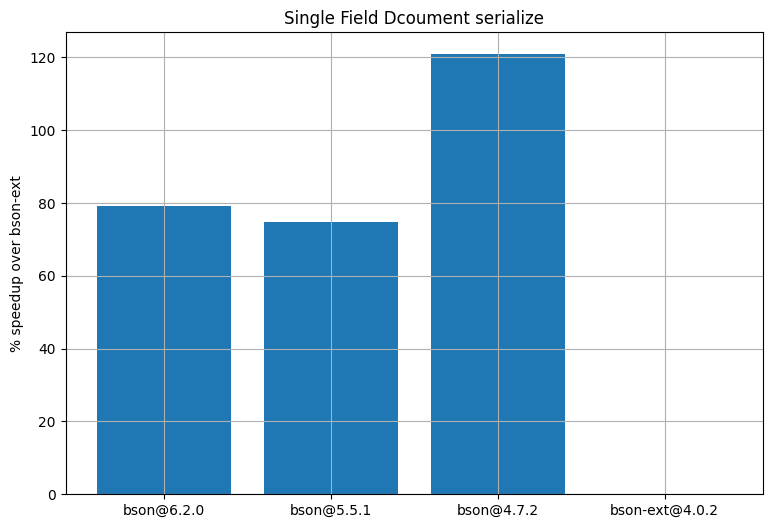

In [11]:
longResults = documents['longResults.csv']

createSimpleGraphPct(longResults, '_singleFieldDocument._serialize', 'Single Field Dcoument serialize')

# Double

## Serialize

### Single Field Document and Single Element Array

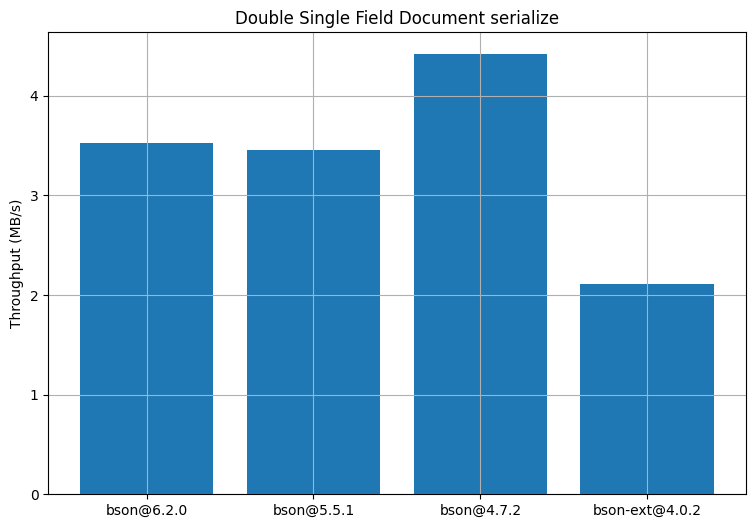

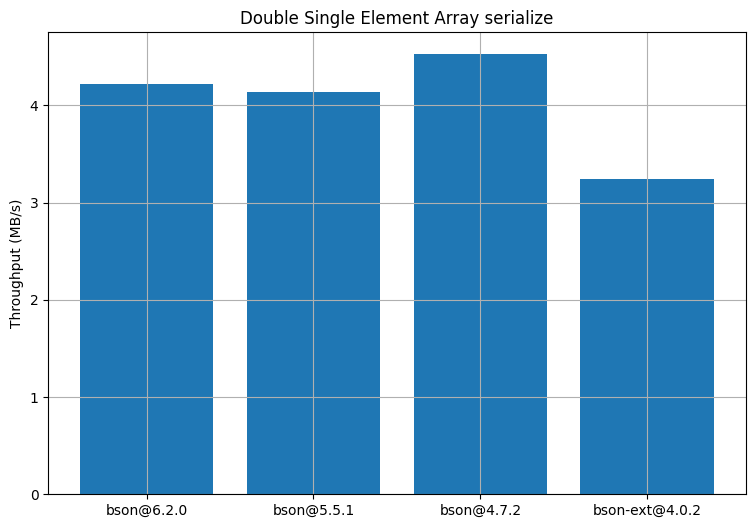

In [13]:
doubleResults = documents['doubleResults.csv']
createSimpleGraph(doubleResults, '_singleFieldDocument._serialize', 'Double Single Field Document serialize')
createSimpleGraph(doubleResults, '_singleElementArray._serialize', 'Double Single Element Array serialize')


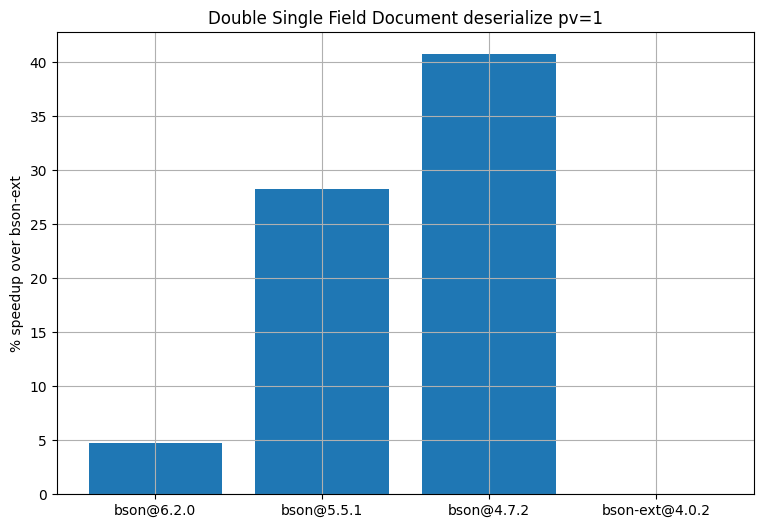

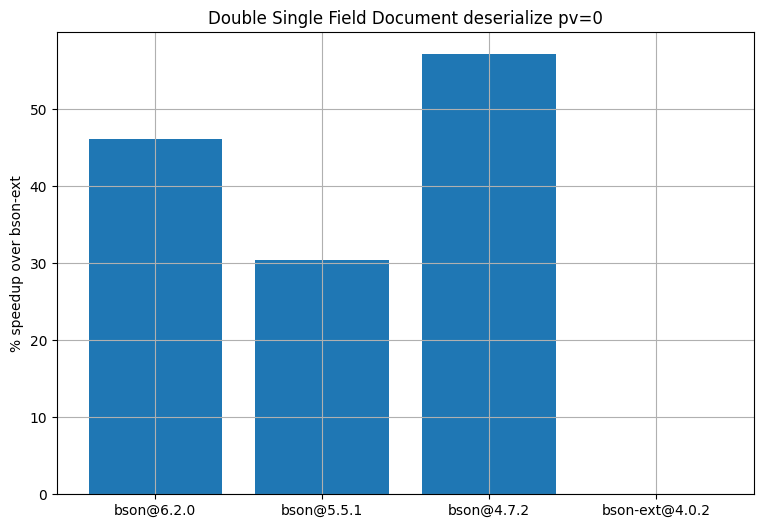

In [14]:
createSimpleGraphPct(doubleResults, '_singleFieldDocument._deserialize', 'Double Single Field Document deserialize pv=1', promoteValues='1')
createSimpleGraphPct(doubleResults, '_singleFieldDocument._deserialize', 'Double Single Field Document deserialize pv=0', promoteValues='0')

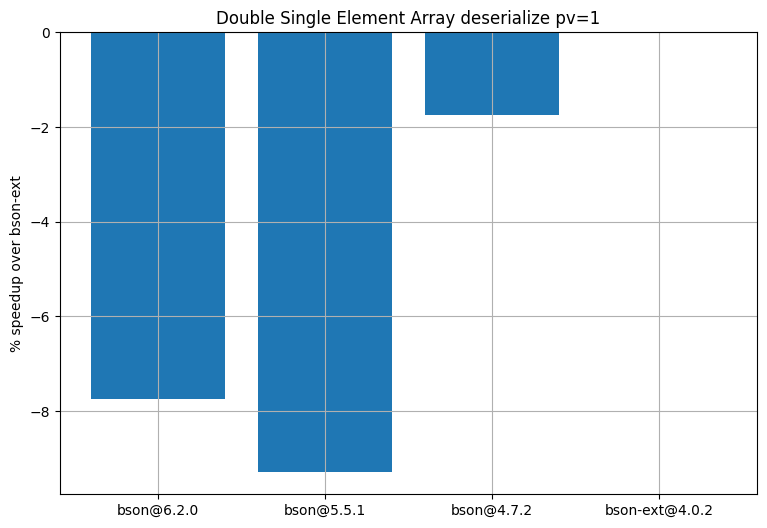

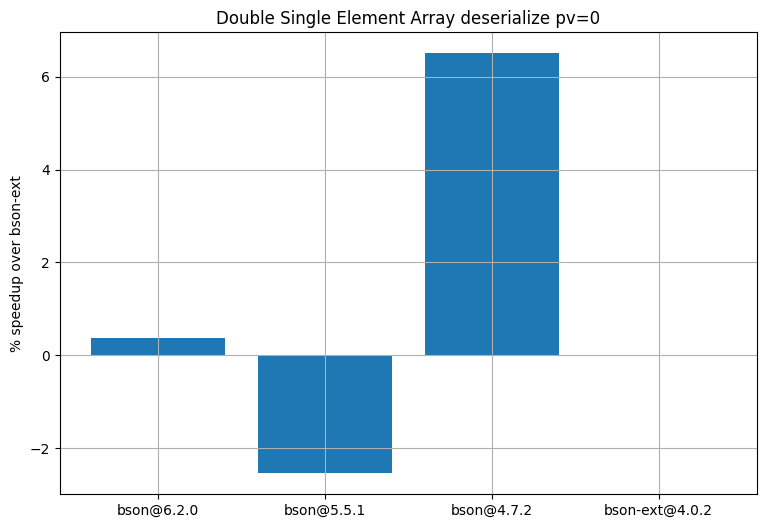

In [15]:

createSimpleGraphPct(doubleResults, '_singleElementArray._deserialize', 'Double Single Element Array deserialize pv=1', promoteValues='1')
createSimpleGraphPct(doubleResults, '_singleElementArray._deserialize', 'Double Single Element Array deserialize pv=0', promoteValues='0')

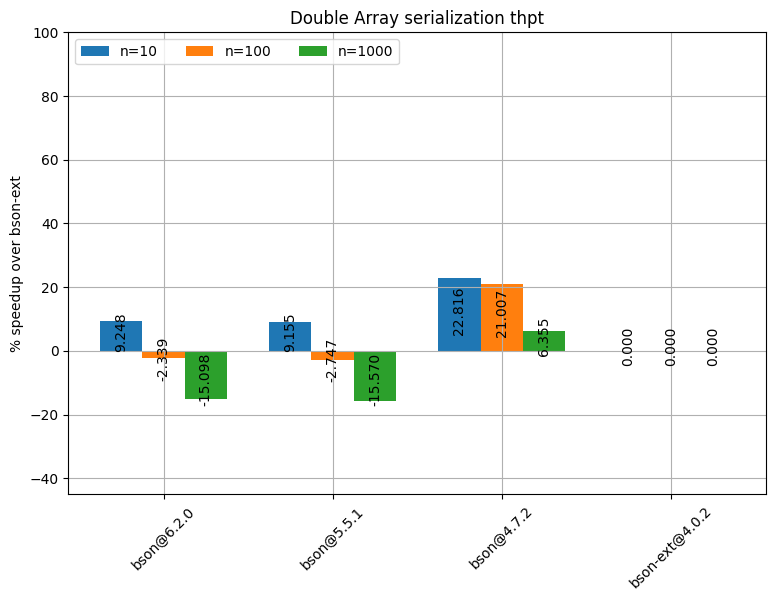

In [16]:
createArrayGraphPct(documents['doubleResults.csv'], 'serialize', 'Double Array serialization thpt')

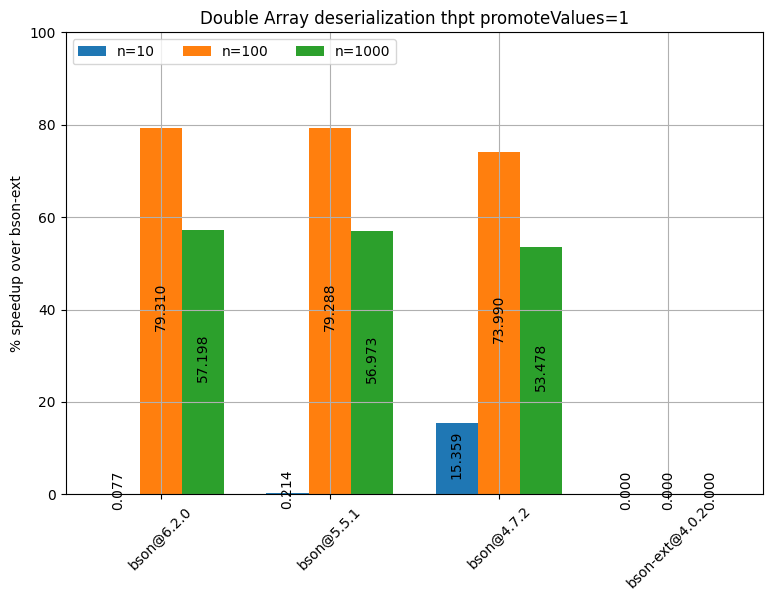

In [17]:
createArrayGraphPct(documents['doubleResults.csv'], 'deserialize', 'Double Array deserialization thpt promoteValues=1', promoteValues='1', ylim0=0)


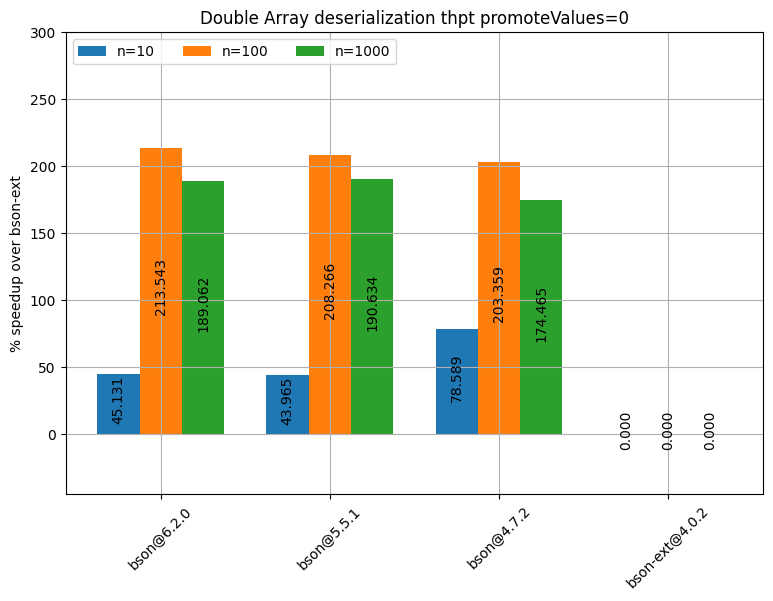

In [18]:
createArrayGraphPct(documents['doubleResults.csv'], 'deserialize', 'Double Array deserialization thpt promoteValues=0', promoteValues='0', ylim1=300)


In [19]:
# Date
dateResults = documents['dateResults.csv']

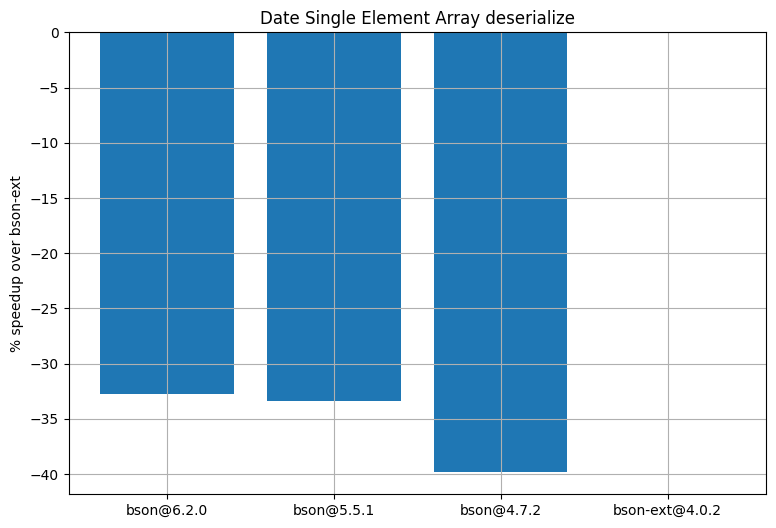

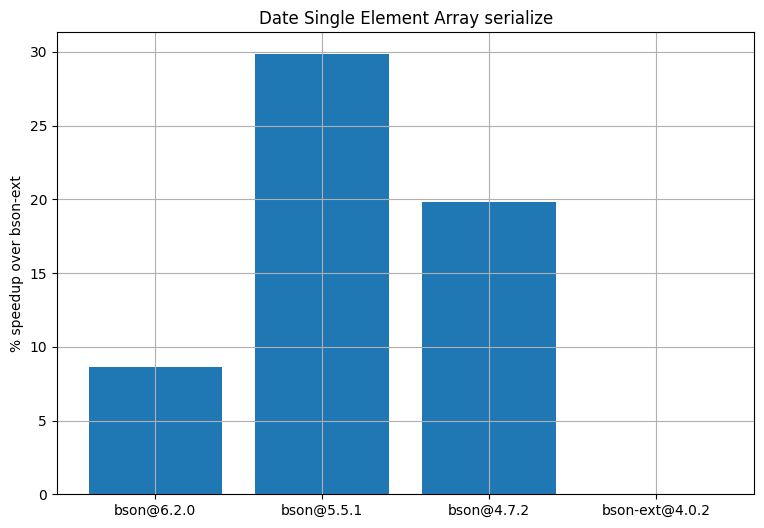

In [20]:
## Single element Array
createSimpleGraphPct(dateResults, '_singleElementArray._deserialize', 'Date Single Element Array deserialize')

createSimpleGraphPct(dateResults, '_singleElementArray._serialize', 'Date Single Element Array serialize')

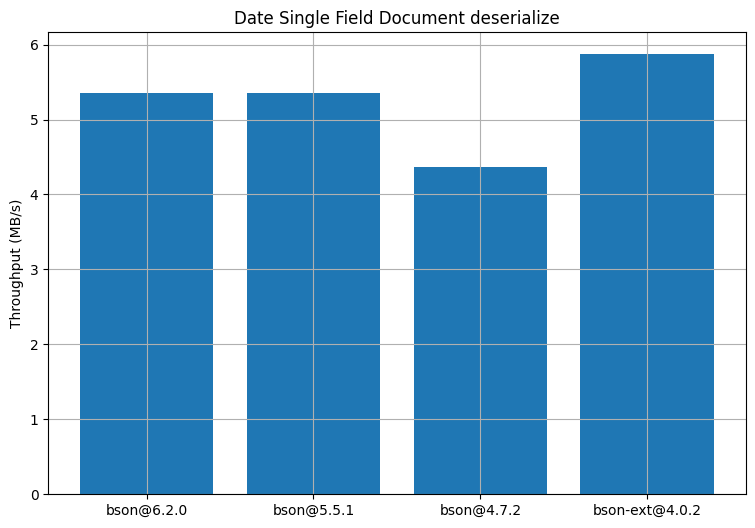

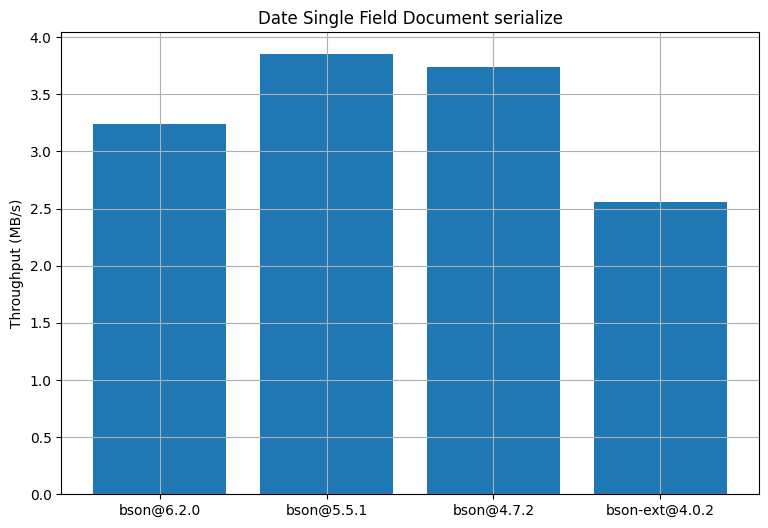

In [21]:
## Single field document
createSimpleGraph(dateResults, '_singleFieldDocument._deserialize', 'Date Single Field Document deserialize')

createSimpleGraph(dateResults, '_singleFieldDocument._serialize', 'Date Single Field Document serialize')

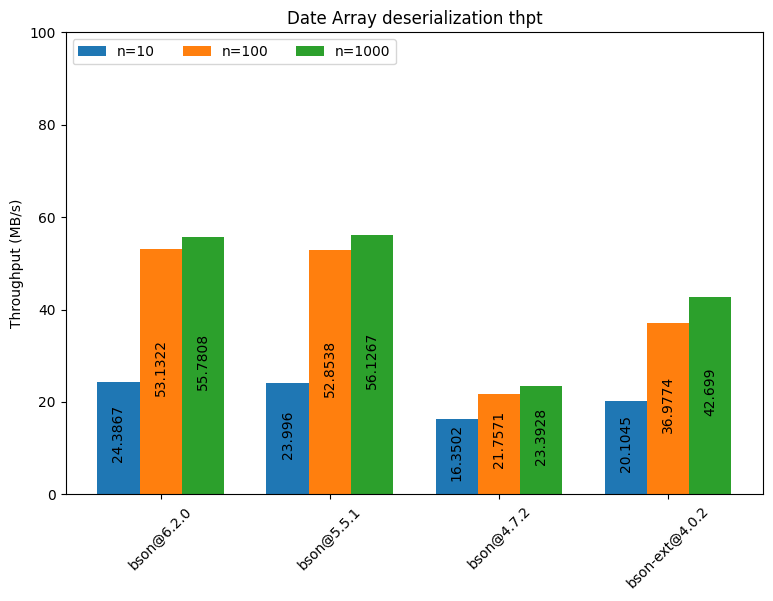

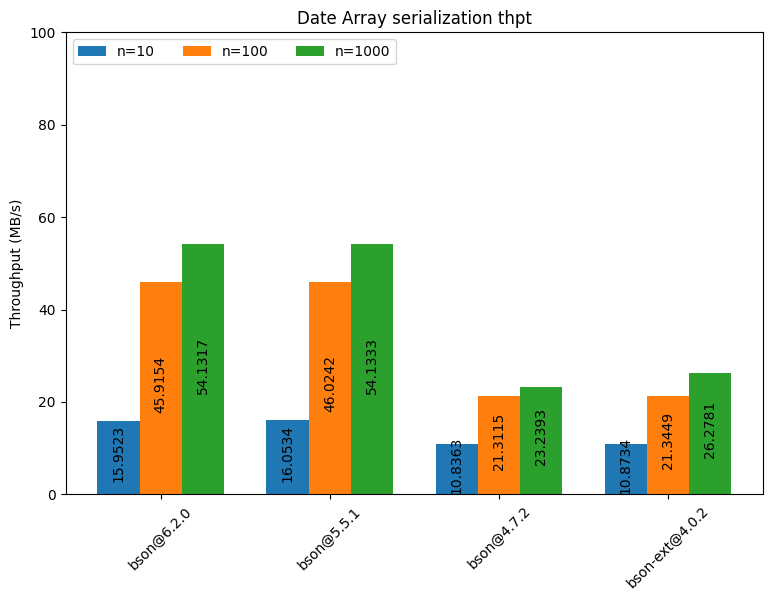

In [22]:
## Array
createArrayGraph(dateResults, 'deserialize', 'Date Array deserialization thpt')
createArrayGraph(dateResults, 'serialize', 'Date Array serialization thpt')

In [23]:
# Null
nullResults = documents['nullResults.csv']

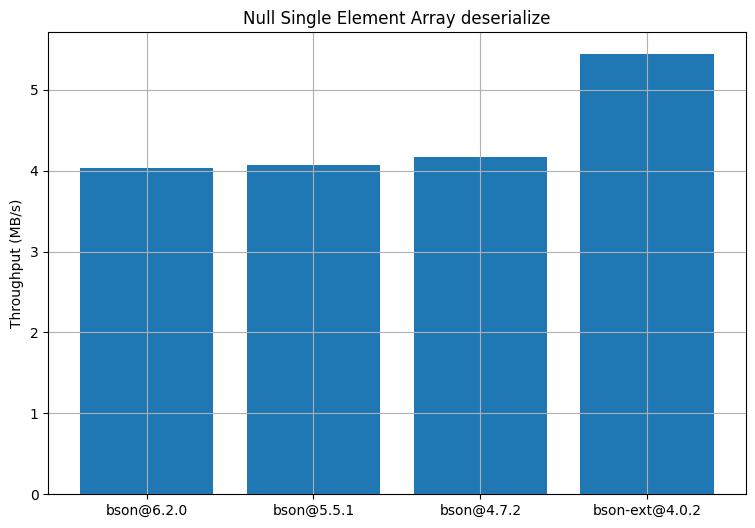

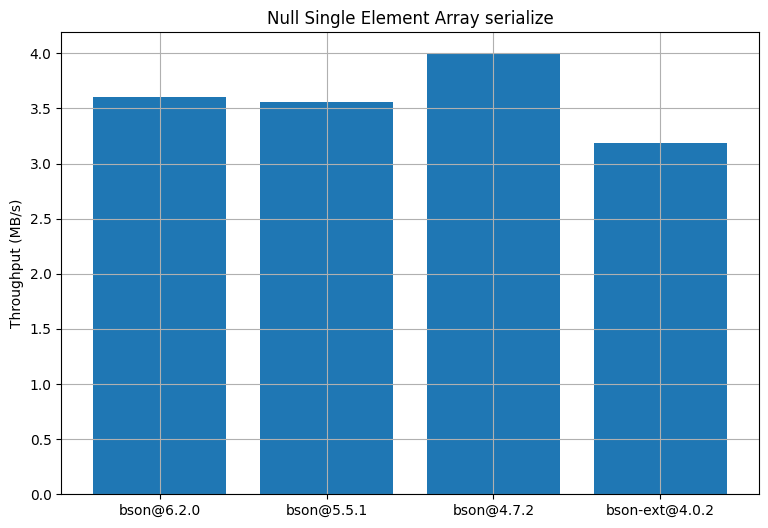

In [24]:
## Single element Array
createSimpleGraph(nullResults, '_singleElementArray._deserialize', 'Null Single Element Array deserialize')

createSimpleGraph(nullResults, '_singleElementArray._serialize', 'Null Single Element Array serialize')

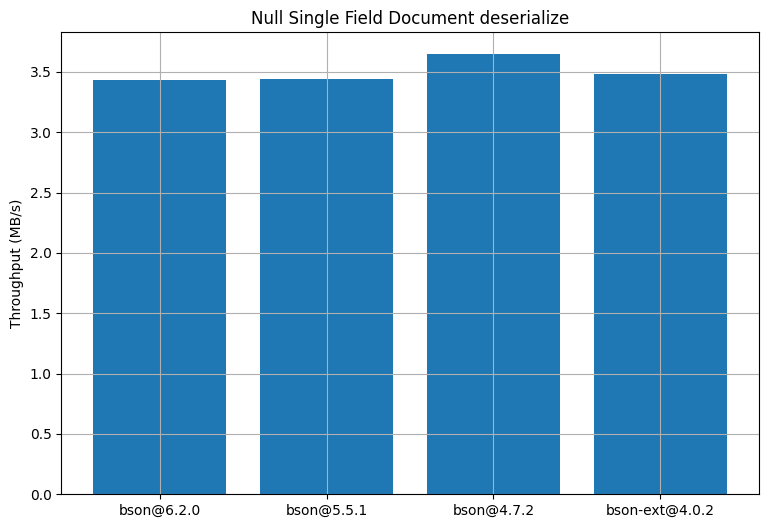

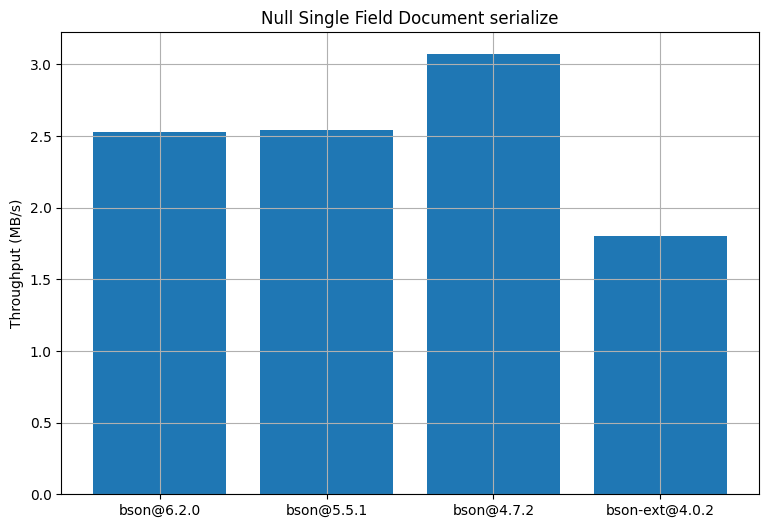

In [25]:
## Single field document
createSimpleGraph(nullResults, '_singleFieldDocument._deserialize', 'Null Single Field Document deserialize')

createSimpleGraph(nullResults, '_singleFieldDocument._serialize', 'Null Single Field Document serialize')

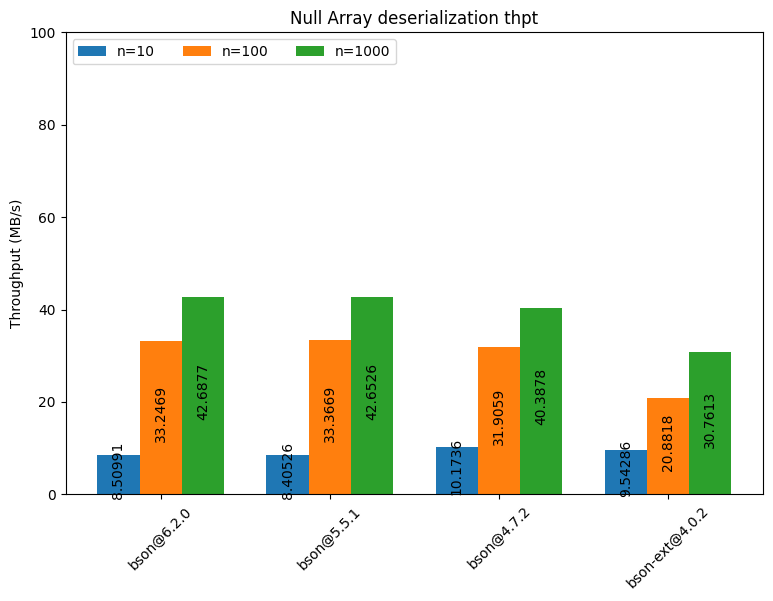

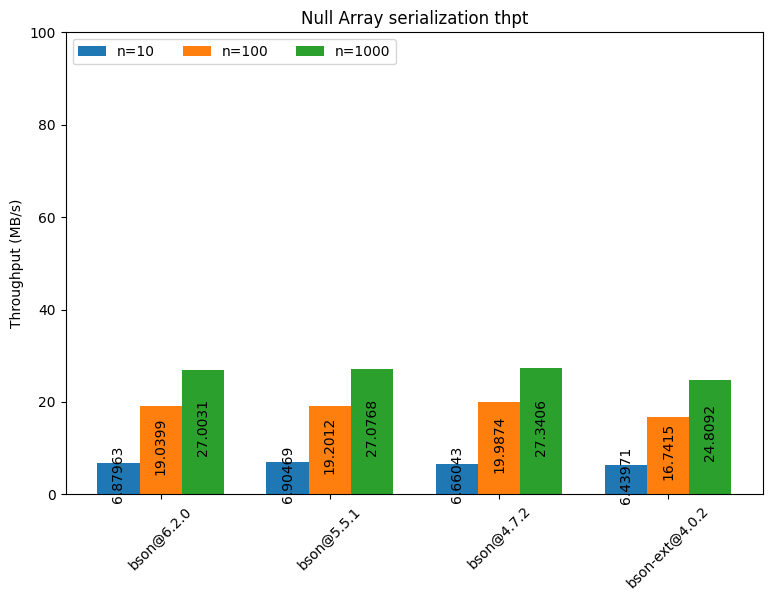

In [26]:
## Array
createArrayGraph(nullResults, 'deserialize', 'Null Array deserialization thpt')
createArrayGraph(nullResults, 'serialize', 'Null Array serialization thpt')

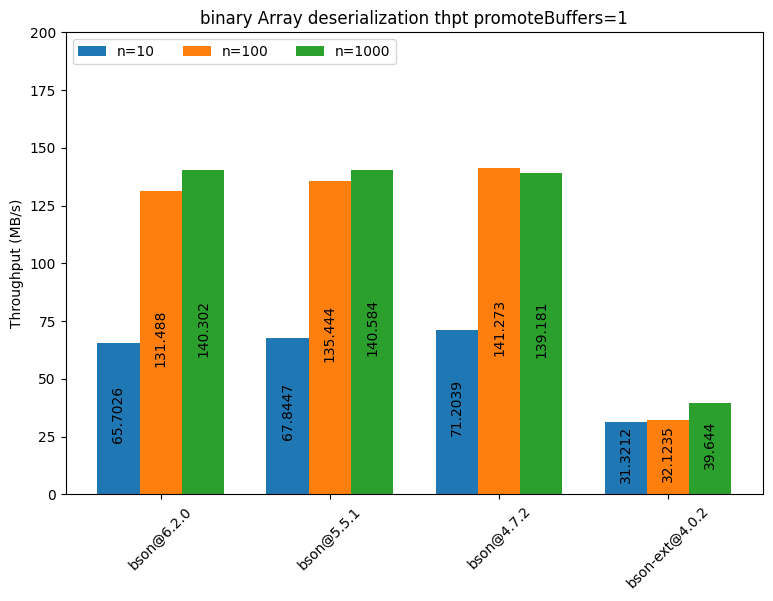

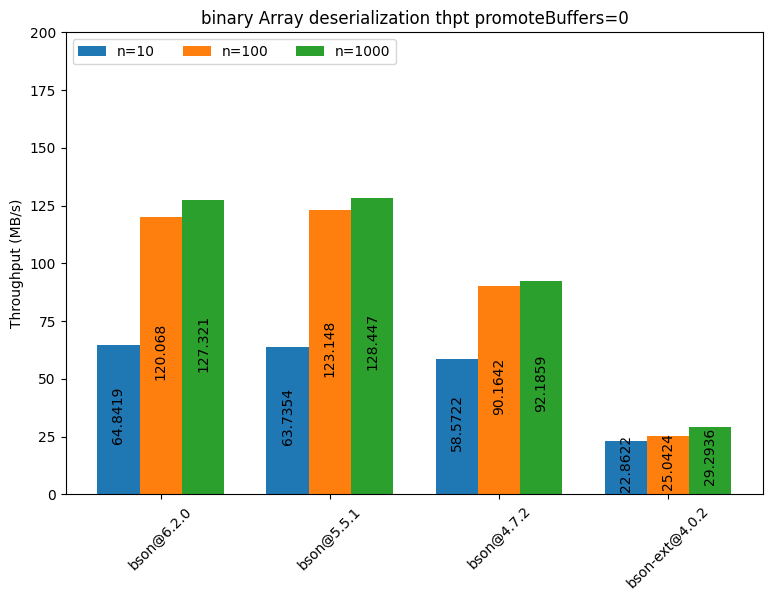

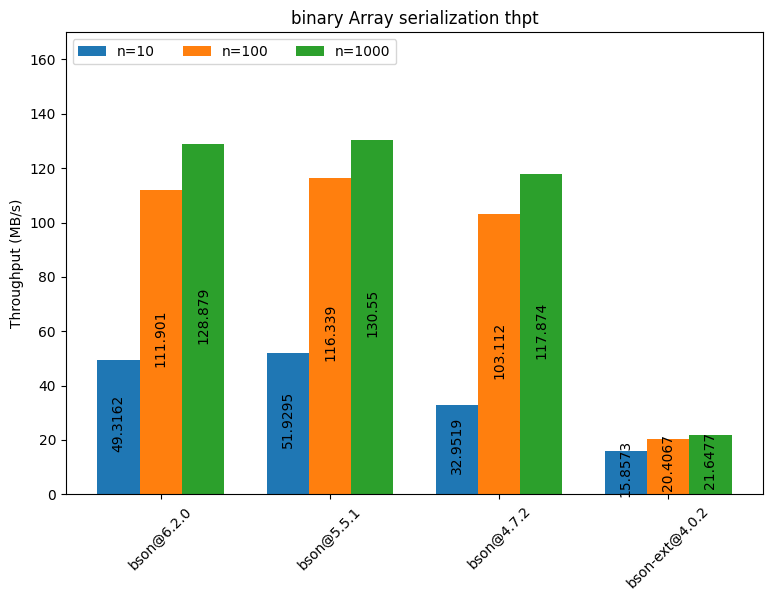

In [27]:
# Binary
binaryResults = documents['binaryResults.csv']
createArrayGraph(binaryResults, 'deserialize', 'binary Array deserialization thpt promoteBuffers=1', promoteBuffers='1', ylim=200)
createArrayGraph(binaryResults, 'deserialize', 'binary Array deserialization thpt promoteBuffers=0', promoteBuffers='0', ylim=200)

createArrayGraph(binaryResults, 'serialize', 'binary Array serialization thpt', ylim=170)

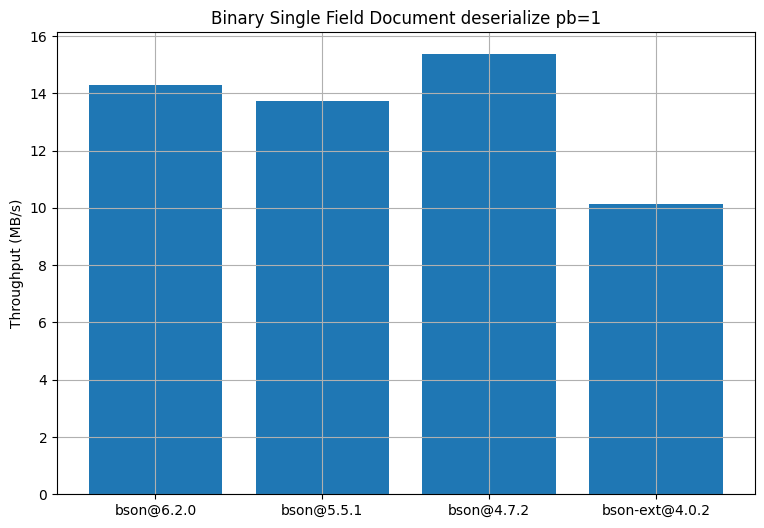

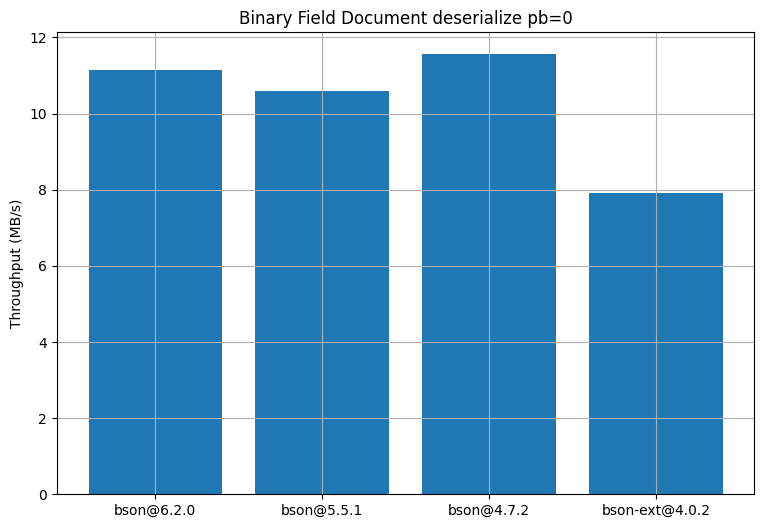

In [28]:
## Single Field Document

createSimpleGraph(binaryResults, '_singleFieldDocument._deserialize', 'Binary Single Field Document deserialize pb=1', promoteBuffers='1')
createSimpleGraph(binaryResults, '_singleFieldDocument._deserialize', 'Binary Field Document deserialize pb=0', promoteBuffers='0')

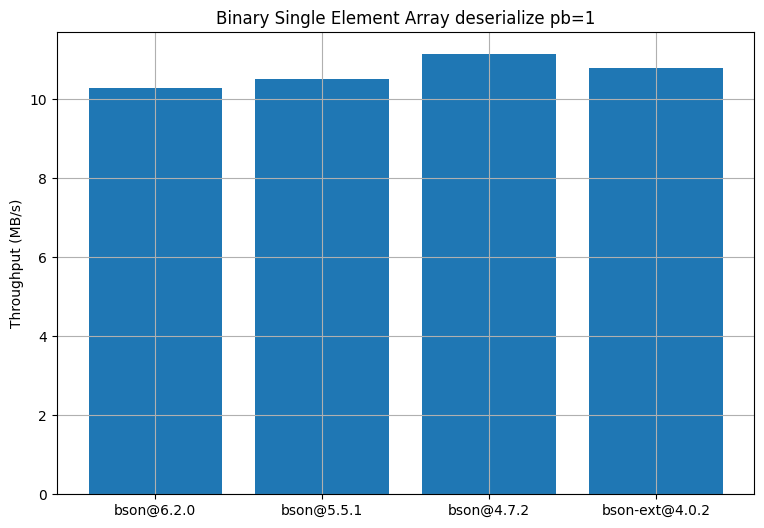

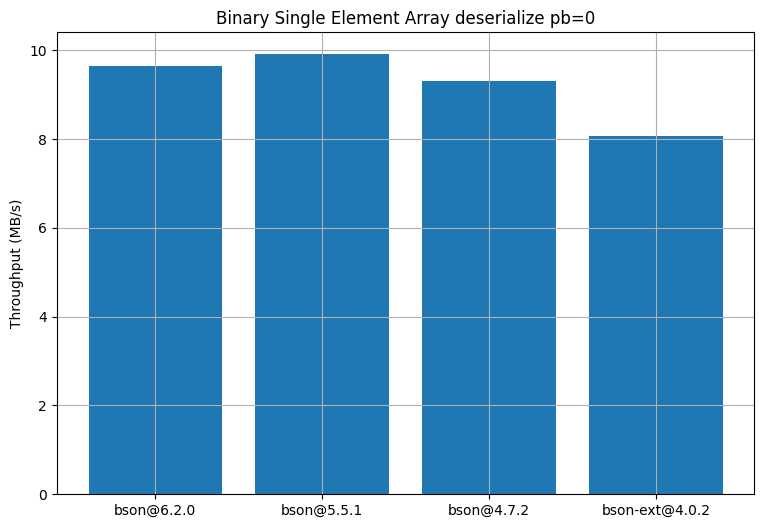

In [29]:
## Single Element Array
createSimpleGraph(binaryResults, '_singleElementArray._deserialize', 'Binary Single Element Array deserialize pb=1', promoteBuffers='1')
createSimpleGraph(binaryResults, '_singleElementArray._deserialize', 'Binary Single Element Array deserialize pb=0', promoteBuffers='0')

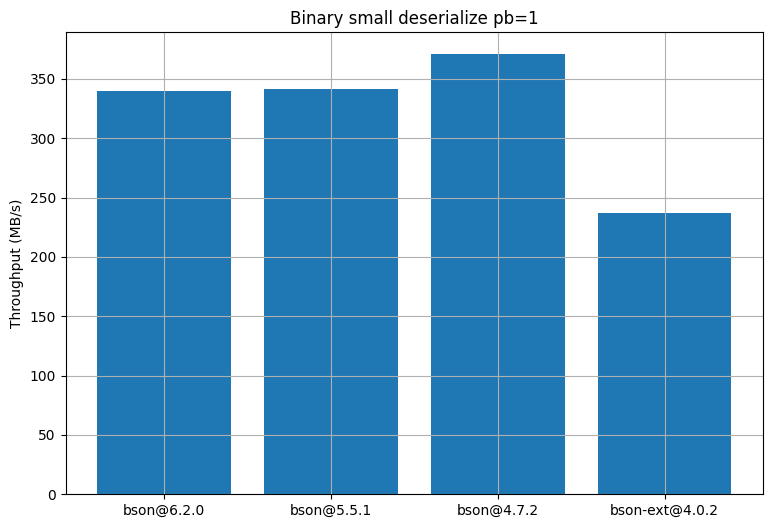

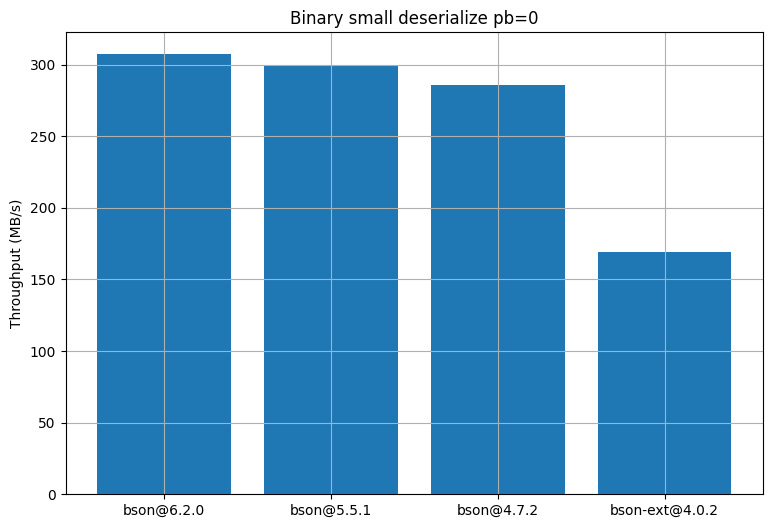

In [30]:
## small
createSimpleGraph(binaryResults, '_small._deserialize', 'Binary small deserialize pb=1', promoteBuffers='1')
createSimpleGraph(binaryResults, '_small._deserialize', 'Binary small deserialize pb=0', promoteBuffers='0')

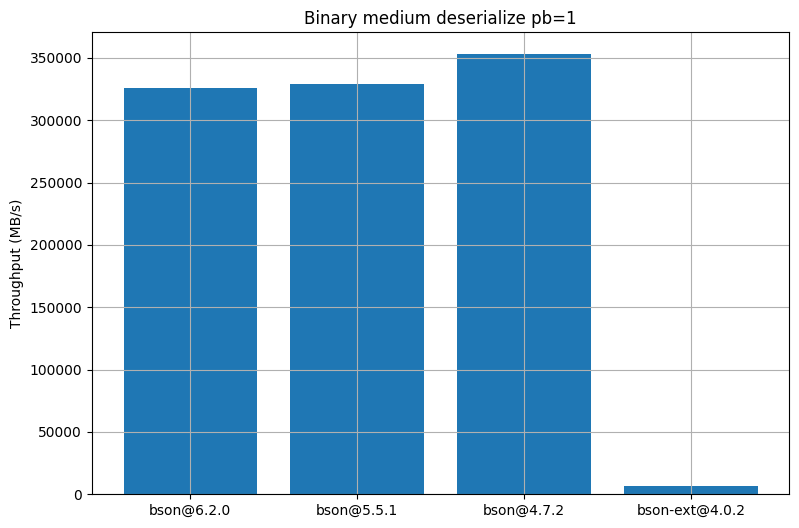

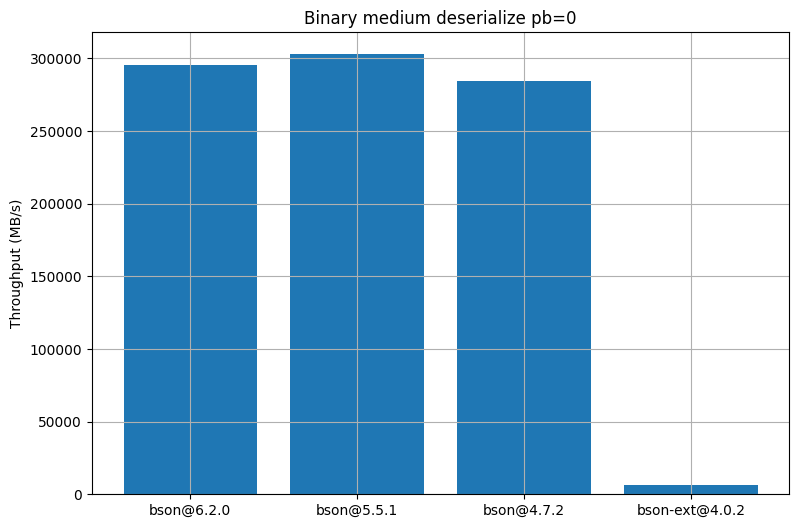

In [31]:
createSimpleGraph(binaryResults, '_medium._deserialize', 'Binary medium deserialize pb=1', promoteBuffers='1')
createSimpleGraph(binaryResults, '_medium._deserialize', 'Binary medium deserialize pb=0', promoteBuffers='0')

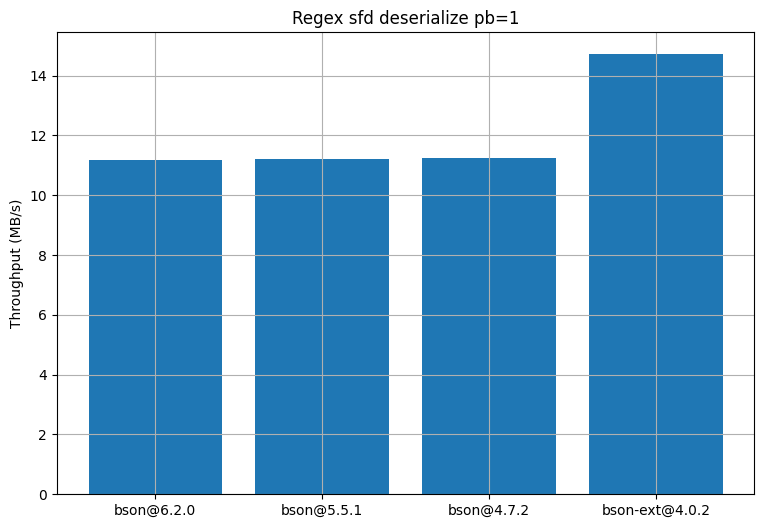

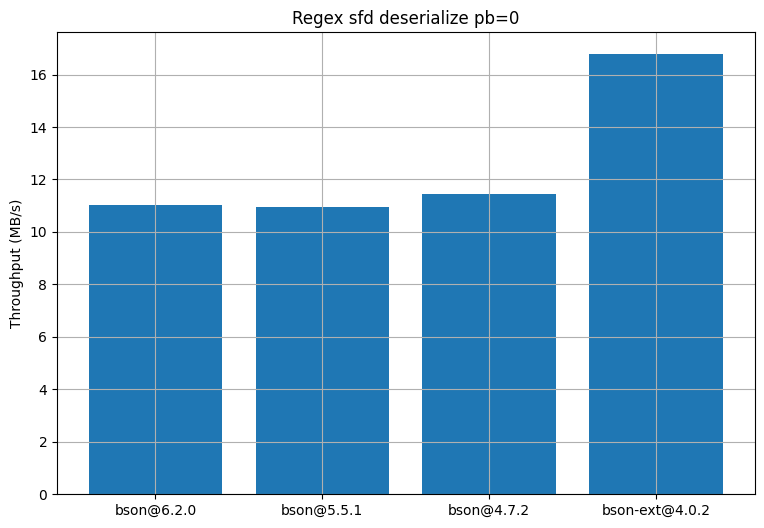

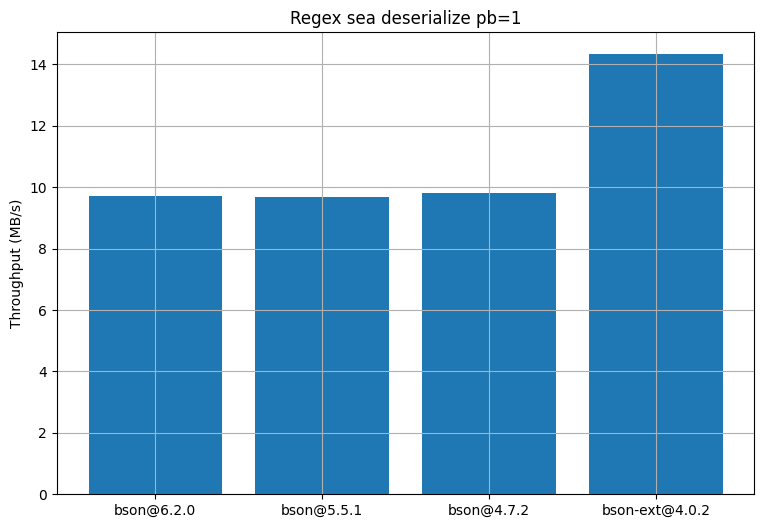

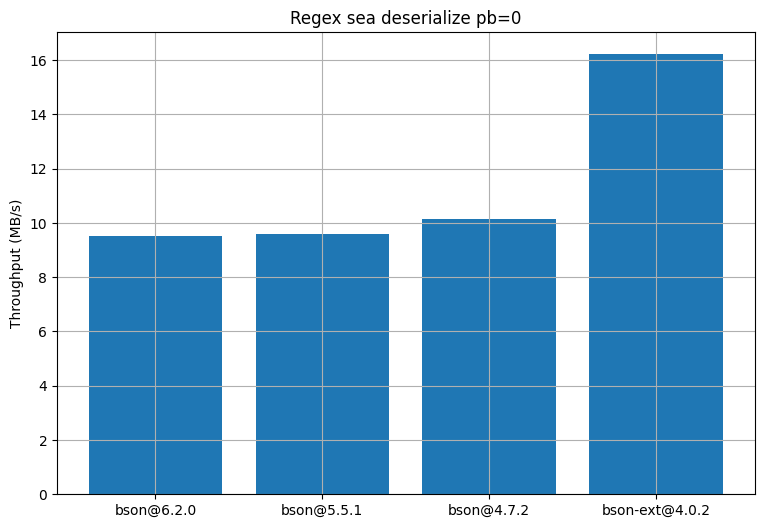

NameError: name 'df' is not defined

In [32]:
# Regex deserialize
regexResults = documents['regexResults.csv']
createSimpleGraph(regexResults, '_singleFieldDocument._deserialize', 'Regex sfd deserialize pb=1', bsonRegExp='1')
createSimpleGraph(regexResults, '_singleFieldDocument._deserialize', 'Regex sfd deserialize pb=0', bsonRegExp='0')

createSimpleGraph(regexResults, '_singleElementArray._deserialize', 'Regex sea deserialize pb=1', bsonRegExp='1')
createSimpleGraph(regexResults, '_singleElementArray._deserialize', 'Regex sea deserialize pb=0', bsonRegExp='0')

createArrayGraph(df, 'deserialize', f'Regex Array deserialization bsonRegExp=1', bsonRegExp='1')
createArrayGraph(df, 'deserialize', f'Regex Array deserialization bsonRegExp=0', bsonRegExp='0')

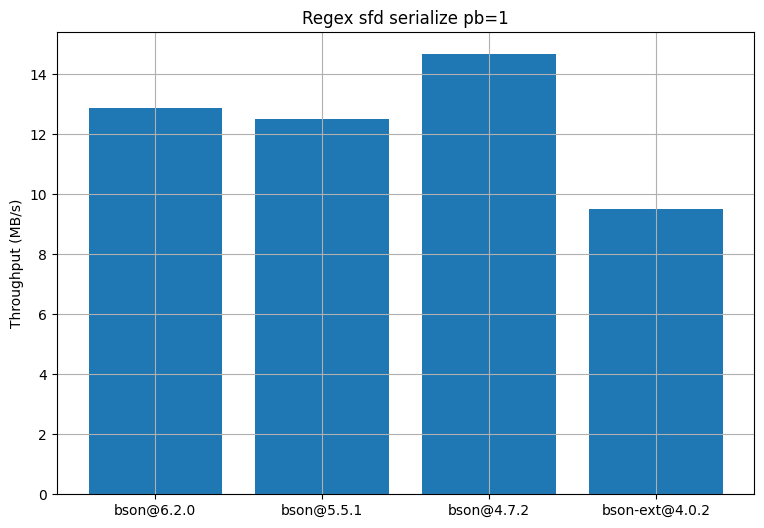

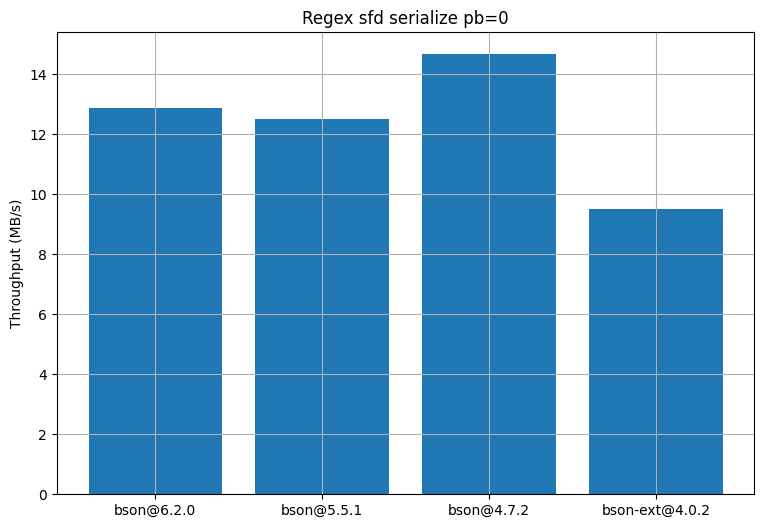

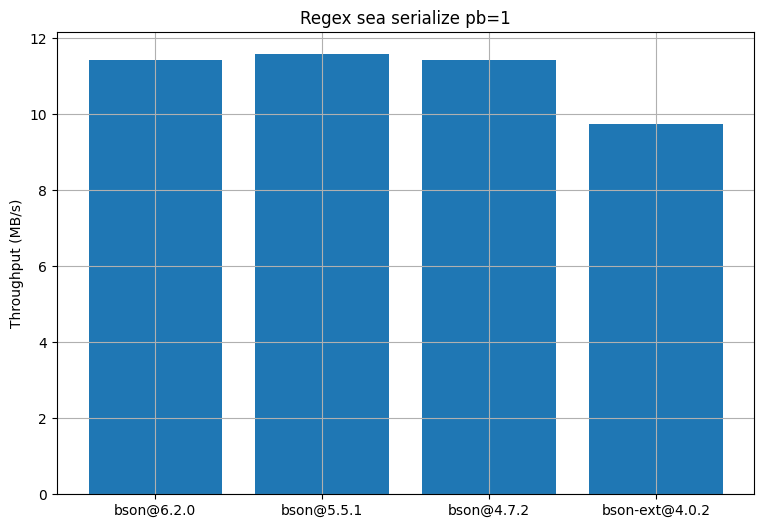

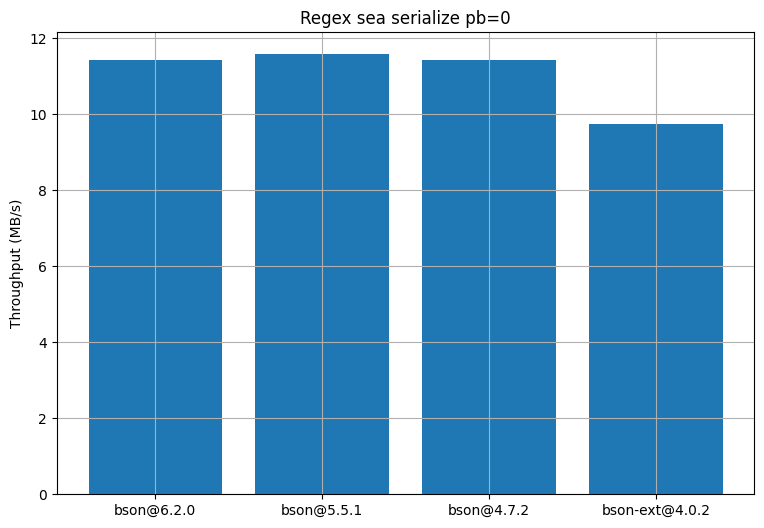

NameError: name 'df' is not defined

In [33]:
# Regex serialize
regexResults = documents['regexResults.csv']
createSimpleGraph(regexResults, '_singleFieldDocument._serialize', 'Regex sfd serialize pb=1')
createSimpleGraph(regexResults, '_singleFieldDocument._serialize', 'Regex sfd serialize pb=0')

createSimpleGraph(regexResults, '_singleElementArray._serialize', 'Regex sea serialize pb=1')
createSimpleGraph(regexResults, '_singleElementArray._serialize', 'Regex sea serialize pb=0')

createArrayGraph(df, 'serialize', f'Regex Array serialization bsonRegExp=1', bsonRegExp='1')
createArrayGraph(df, 'serialize', f'Regex Array serialization bsonRegExp=0', bsonRegExp='0')

In [ ]:
for t in ['int32', 'double']:
    df = documents[f'{t}Results.csv']
    
    # Create graphs for sfd and sea docs
    createSimpleGraph(df, '_singleFieldDocument._deserialize', f'{t} Single Field Document deserialization promoteValues=1', promoteValues='1')
    createSimpleGraph(df, '_singleFieldDocument._deserialize', f'{t} Single Field Document deserialization promoteValues=0', promoteValues='0')
    
    createSimpleGraph(df, '_singleElementArray._deserialize', f'{t} Single Element Array deserialization promoteValues=1', promoteValues='1')
    createSimpleGraph(df, '_singleElementArray._deserialize', f'{t} Single Element Array deserialization promoteValues=0', promoteValues='0')
    # Create graphs for arrays
    createArrayGraph(df, 'deserialize', f'{t} Array deserialization with promoteValues set to 1', promoteValues='1') 
    createArrayGraph(df, 'deserialize', f'{t} Array deserialization with promoteValues set to 0', promoteValues='0') 


In [ ]:
for t in ['maxkey', 'minkey', 'null', 'objectid', 'decimal128']:
    df = documents[f'{t}Results.csv']
    
    # Create graphs for sfd and sea docs
    createSimpleGraph(df, '_singleFieldDocument._deserialize', f'{t} Single Field Document deserialization')
    
    createSimpleGraph(df, '_singleElementArray._deserialize', f'{t} Single Element Array deserialization')
    # Create graphs for arrays
    createArrayGraph(df, 'deserialize', f'{t} Array deserialization')

In [ ]:
for t in ['maxkey', 'minkey', 'null', 'objectid', 'decimal128']:
    df = documents[f'{t}Results.csv']
    
    # Create graphs for sfd and sea docs
    createSimpleGraph(df, '_singleFieldDocument._serialize', f'{t} Single Field Document serialization')
    
    createSimpleGraph(df, '_singleElementArray._serialize', f'{t} Single Element Array serialization')
    # Create graphs for arrays
    createArrayGraph(df, 'serialize', f'{t} Array serialization')
     

In [ ]:
df = documents[f'int32Results.csv']
createSimpleGraphPct(df, '_singleElementArray._serialize', f'{t} Single Element Array deserialization')
createArrayGraphPct(df, 'serialize', 'int32', ylim0=-20,ylim1=30)

In [ ]:
stringResults = documents['stringResults.csv']

bsonExtDeser= stringResults.loc[
                            (stringResults['library'].str.contains('bson-ext')) &
                            (stringResults['test_name'].str.contains('deserialize'))
]

bsonUTF8Disabled = filterFor(stringResults, '_deserialize',utf8Validation='0')

stringResultsUTF8Disabled = pd.concat([bsonUTF8Disabled, bsonExtDeser])
#print(string)
createSimpleGraphPct(stringResults, '_singleElementArray._deserialize', 'String Single Element Array deserialize utf8Validation=true', utf8Validation='1')
#createSimpleGraphPct(stringResults, '_singleElementArray._deserialize', 'String Single Element Array deserialize utf8Validation=false')

createSimpleGraphPct(stringResultsUTF8Disabled, '_singleElementArray._deserialize', 'String Single Element Array deserialize utf8Validation=false' )

createArrayGraphPct(stringResults, 'deserialize', 'string', utf8Validation='1')
createArrayGraphPct(stringResultsUTF8Disabled, 'deserialize', 'string')

In [ ]:
# Mixed Tests

mixedResults = documents['mixedDocumentsResults.csv']

# Tweet and bestbuy_medium
mediumDocs = mixedResults.loc[
    (
    (mixedResults['test_name'].str.contains('tweet')) |
    (mixedResults['test_name'].str.contains('bestbuy'))
    ) & (mixedResults['test_name'].str.contains('._deserialize'))
]


createSimpleGraphPct(mediumDocs, 'tweet._deserialize', 'Tweet deserialize')

In [ ]:
mixed = mixedResults.loc[
    mixedResults['test_name'].str.contains('mixed')
]

createMixedGraphs(mixedResults, 'deserialize', 'test')

In [ ]:
createMixedGraphs(mixedResults, 'serialize', 'test')

## Analysis

### Deserialization
#### Mixed Documents
bson-ext failed to deserialize bestbuy_medium.json


### Serialization